## Identify trajectories on AMP myeloid cell differentiation
## Identify if any complement components align with any myeloid trajectories using Possion regression or Negative binomial regression

In [6]:
# library(monocle3)
library(monocle)
library(ggplot2)
library(Seurat)
library(harmony)
library(magrittr)
library(gridExtra)
library(ggthemes)
library(reticulate)
library(ggbeeswarm)
library(ggrepel)
library(plyr)
library(ggplot2)
library(gridExtra)
library(ggthemes)
library(dplyr)
library(RColorBrewer)
library(ggbeeswarm)
library(ggrepel)
library(MASS)
library(matrixStats)
library(viridis)
library(grid)
library(singlecellmethods)
library(umap)
library(ggpubr)

In [4]:
FindVariableGenesBatch <- function(exprs_mat, meta_df, genes_exclude = NULL, ngenes_use = 1e3, expr_min = .1) {
    if (!is.null(genes_exclude)) {
        genes_use <- setdiff(row.names(exprs_mat), genes_exclude)
    }
    x_res <- split(meta_df$cell, meta_df$sample) %>% lapply(function(x) {
        FindVariableGenesSeurat(exprs_mat[genes_use, x]) %>% 
            subset(gene.mean >= expr_min) %>% 
            tibble::rownames_to_column("gene") %>% 
            dplyr::arrange(-gene.dispersion) %>%
            head(ngenes_use)
    })
    data.table(Reduce(rbind, x_res))[, .N, by = gene][order(-N)]    
}



FindVariableGenesSeurat <- function (data, x.low.cutoff = 0.1, x.high.cutoff = 8,
                                     y.cutoff = 1, y.high.cutoff = Inf, num.bin = 0,
                                     binning.method = "equal_width", sort.results = TRUE,
                                     display.progress = TRUE, ...)
{
    genes.use <- rownames(data)
    if (class(data) != "dgCMatrix") {
        data <- as(as.matrix(data), "dgCMatrix")
    }
    ## (1) get means and variances
    gene.mean <- FastExpMean(data, display.progress)
    names(gene.mean) <- genes.use
    gene.dispersion <- FastLogVMR(data, display.progress)
    names(gene.dispersion) <- genes.use

    gene.dispersion[is.na(x = gene.dispersion)] <- 0
    gene.mean[is.na(x = gene.mean)] <- 0

    mv.df <- data.frame(gene.mean, gene.dispersion)
    rownames(mv.df) <- rownames(data)

    ## (OPTIONAL) do the binning correction
    if (num.bin > 0) {
      if (binning.method == "equal_width") {
          data_x_bin <- cut(x = gene.mean, breaks = num.bin)
      }
      else if (binning.method == "equal_frequency") {
          data_x_bin <- cut(x = gene.mean, breaks = c(-1, quantile(gene.mean[gene.mean >
              0], probs = seq(0, 1, length.out = num.bin))))
     }
      else {
          stop(paste0("Invalid selection: '", binning.method,
              "' for 'binning.method'."))
      }
      names(x = data_x_bin) <- names(x = gene.mean)
      mean_y <- tapply(X = gene.dispersion, INDEX = data_x_bin,
          FUN = mean)
      sd_y <- tapply(X = gene.dispersion, INDEX = data_x_bin,
          FUN = sd)
      gene.dispersion.scaled <- (gene.dispersion - mean_y[as.numeric(x = data_x_bin)])/sd_y[as.numeric(x = data_x_bin)]
      gene.dispersion.scaled[is.na(x = gene.dispersion.scaled)] <- 0
      ##names(gene.dispersion.scaled) <- names(gene.mean)

      mv.df$gene.dispersion.scaled <- gene.dispersion.scaled
    }

    return(mv.df)
}

environment(FindVariableGenesSeurat) <- asNamespace("Seurat")

ScaleDataSeurat <- function (data.use, margin = 1, scale.max = 10,
                                block.size = 1000) {

    if (margin == 2) data.use %<>% t
    max.block <- ceiling(nrow(data.use)/block.size)

    ## Define data and functions to use in sparse and dense cases
    if (class(data.use) == "dgCMatrix" | class(data.use) == "dgTMatrix") {
        scale_fxn <- function(x) {
            FastSparseRowScale(mat = x, scale = TRUE, center = TRUE,
                               scale_max = scale.max, display_progress = FALSE)
        }
    } else {
        scale_fxn <- function(x) {
            FastRowScale(mat = x, scale = TRUE, center = TRUE,
                               scale_max = scale.max, display_progress = FALSE)
       }
        data.use <- as.matrix(data.use)
    }

    ## Do scaling, at once or in chunks
    if (max.block == 1) {
        scaled.data <- scale_fxn(data.use)
    } else {
        scaled.data <- matrix(NA, nrow(data.use), ncol(data.use))
        for (i in 1:max.block) {
            idx.min <- (block.size * (i - 1))
            idx.max <- min(nrow(data.use), (block.size * i - 1) + 1)
            my.inds <- idx.min:idx.max
            scaled.data[my.inds, ] <- scale_fxn(data.use[my.inds, , drop = F])
        }
    }

    colnames(scaled.data) <- colnames(data.use)
    row.names(scaled.data) <- row.names(data.use)
    scaled.data[is.na(scaled.data)] <- 0
    if (margin == 2) scaled.data %<>% t
    return(scaled.data)
}
environment(ScaleDataSeurat) <- asNamespace("Seurat")


fig.size <- function(height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}

SingleFeaturePlotSeurat <- function (data.use, feature, data.plot, pt.size, pch.use, cols.use,
    dim.codes, min.cutoff, max.cutoff, coord.fixed, no.axes,
    no.title = FALSE, no.legend, dark.theme, vector.friendly = FALSE,
    png.file = NULL, png.arguments = c(10, 10, 100))
{
    if (vector.friendly) {
        previous_call <- blank_call <- png_call <- match.call()
        blank_call$pt.size <- -1
        blank_call$vector.friendly <- FALSE
        png_call$no.axes <- TRUE
        png_call$no.legend <- TRUE
        png_call$vector.friendly <- FALSE
        png_call$no.title <- TRUE
        blank_plot <- eval(blank_call, sys.frame(sys.parent()))
        png_plot <- eval(png_call, sys.frame(sys.parent()))
        png.file <- SetIfNull(x = png.file, default = paste0(tempfile(),
            ".png"))
        ggsave(filename = png.file, plot = png_plot, width = png.arguments[1],
            height = png.arguments[2], dpi = png.arguments[3])
        to_return <- AugmentPlot(blank_plot, png.file)
        file.remove(png.file)
        return(to_return)
    }
    idx.keep <- which(!is.na(data.use[feature, ]))
    data.gene <- data.frame(data.use[feature, idx.keep])
#     data.gene <- na.omit(object = data.frame(data.use[feature,
#         ]))
    min.cutoff <- SetQuantile(cutoff = min.cutoff, data = data.gene)
    max.cutoff <- SetQuantile(cutoff = max.cutoff, data = data.gene)
    data.gene <- sapply(X = data.gene, FUN = function(x) {
        return(ifelse(test = x < min.cutoff, yes = min.cutoff,
            no = x))
    })
    data.gene <- sapply(X = data.gene, FUN = function(x) {
        return(ifelse(test = x > max.cutoff, yes = max.cutoff,
            no = x))
    })
    data_plot <- data.plot[idx.keep, ]
    data_plot$gene <- data.gene
    if (length(x = cols.use) == 1) {
        brewer.gran <- brewer.pal.info[cols.use, ]$maxcolors
    }
    else {
        brewer.gran <- length(x = cols.use)
    }
    if (all(data.gene == 0)) {
        data.cut <- 0
    }
    else {
        data.cut <- as.numeric(x = as.factor(x = cut(x = as.numeric(x = data.gene),
            breaks = brewer.gran)))
    }
    data_plot$col <- as.factor(x = data.cut)
    p <- data_plot %>%
        dplyr::arrange(col) %>%
        ggplot(mapping = aes(x = x, y = y))
    if (brewer.gran != 2) {
        if (length(x = cols.use) == 1) {
            p <- p + geom_point(mapping = aes(color = col), size = pt.size,
                shape = pch.use) + #scale_color_brewer(palette = cols.use)
                scale_color_viridis(option = "plasma", end = .9)
        }
        else {
            p <- p + geom_point(mapping = aes(color = col), size = pt.size,
                shape = pch.use) + #scale_color_manual(values = cols.use)
                scale_color_viridis(option = "plasma", end = .9)
        }
    }
    else {
        if (all(data_plot$gene == data_plot$gene[1])) {
            warning(paste0("All cells have the same value of ",
                feature, "."))
            p <- p + geom_point(color = cols.use[1], size = pt.size,
                shape = pch.use)
        }
        else {
            p <- p + geom_point(mapping = aes(color = gene),
                size = pt.size, shape = pch.use) + scale_color_viridis(option = "plasma", end = .9
    )
        }
    }
    if (dark.theme) {
        p <- p + DarkTheme()
    }
    if (no.axes) {
        p <- p + theme(axis.line = element_blank(), axis.text.x = element_blank(),
            axis.text.y = element_blank(), axis.ticks = element_blank(),
            axis.title.x = element_blank(), axis.title.y = element_blank())
        if (!no.title)
            p <- p + labs(title = feature, x = "", y = "")
        if (no.title)
            p <- p + labs(x = "", y = "")
    }
    else {
        if (no.title)
            p <- p + labs(x = dim.codes[1], y = dim.codes[2])
        if (!(no.title))
            p <- p + labs(title = feature) + labs(x = "", y = "")
    }
    if (no.legend) {
        p <- p + theme(legend.position = "none")
    }
    if (coord.fixed) {
        p <- p + coord_fixed()
    }
    return(p)
}
environment(SingleFeaturePlotSeurat) <- asNamespace("Seurat")

PlotFeatures <- function(umap_use, features_plot, exprs_use, cells_use, ncols, pt_size = .5, pt_shape = ".", q_lo = "q10", q_hi = "q90") {
    if (missing(cells_use)) cells_use <- 1:nrow(umap_use)
    if (missing(ncols)) ncols <- round(sqrt(length(features_plot)))
    
    plt_list <- lapply(features_plot, function(feature_use) {
        SingleFeaturePlotSeurat(exprs_use[, cells_use], feature_use, data.frame(x = umap_use[cells_use, 1], y = umap_use[cells_use, 2]),
                                pt.size = pt_size, pch.use = pt_shape, cols.use = c("lightgrey", "blue"),
                                dim.codes = c("UMAP 1", "UMAP 2"), min.cutoff = c(q10 = q_lo), max.cutoff = c(q90 = q_hi),
                                coord.fixed = FALSE, no.axes = FALSE, dark.theme = FALSE, no.legend = TRUE)
    })
    plot_grid(plotlist = plt_list, ncol = ncols)
    #return(plt_list)
}

BuildSNNSeurat <- function (data.use, k.param = 30, prune.SNN = 1/15, nn.eps = 0) {
    my.knn <- nn2(data = data.use, k = k.param, searchtype = "standard", eps = nn.eps)
    nn.ranked <- my.knn$nn.idx

    snn_res <- ComputeSNN(nn_ranked = nn.ranked, prune = prune.SNN)
    rownames(snn_res) <- row.names(data.use)
    colnames(snn_res) <- row.names(data.use)
    return(snn_res)
}
environment(BuildSNNSeurat) <- asNamespace("Seurat")

NormalizeDataSeurat <- function(A, scaling_factor = 1e4, do_ftt = FALSE) {
	A@x <- A@x / rep.int(Matrix::colSums(A), diff(A@p))
    A@x <- scaling_factor * A@x
    if (do_ftt) {
        A@x <- sqrt(A@x) + sqrt(1 + A@x)
    } else {
        A@x <- log(1 + A@x)
    }
	return(A)
}


plot_clusters <- function(cluster_ids, labels, pt_size = 14, umap_use = umap_res, collapse_labels = FALSE) {
    cluster_table <- table(cluster_ids)
    clusters_keep <- names(which(cluster_table > 20))
    plt_df <- umap_use %>% data.frame() %>% cbind(cluster = cluster_ids) %>%
        subset(cluster %in% clusters_keep) 
    if (!missing(labels)) {
        if (collapse_labels) {
            plt_df$cluster <- labels[plt_df$cluster + 1]            
        } else {
            plt_df$cluster <- sprintf("c%d: %s", plt_df$cluster, labels[plt_df$cluster + 1])
        }
    }
    plt_df %>% 
        ggplot(aes(X1, X2, col = factor(cluster))) + geom_point(shape = '.', size = 6, alpha = .7) + 
        geom_label_repel(data = data.table(plt_df)[, .(X1 = mean(X1), X2 = mean(X2)), by = cluster], 
                   aes(label = cluster), size = pt_size, alpha = .8) + 
        theme_void() +
        theme(axis.line = element_line()) +
        guides(col = FALSE)
}

In [16]:
# Load the myeloid harmonized PCs
ref <- readRDS("/Users/zhanfan/OneDrive - The University of Colorado Denver/data/amp_phase2_ra/myeloid_reference_2021-04-29.rds")
hPC <- t(ref$Z_corr)
hPC[1:4,]
dim(hPC)

,harmony_1,harmony_2,harmony_3,harmony_4,harmony_5,harmony_6,harmony_7,harmony_8,harmony_9,harmony_10,harmony_11,harmony_12,harmony_13,harmony_14,harmony_15,harmony_16,harmony_17,harmony_18,harmony_19,harmony_20
4,-7.558558,-1.460409,-5.742807,-3.8531098,0.2229369,-2.8140437,-3.776202,-1.516915,0.3112699,1.711636,1.0394413,0.2608649,0.5282177,0.3003297,0.7996451,-0.6770154,-0.8358810,0.1111477,-0.2389264,-1.1092099
28,-12.019174,-1.008047,-6.388324,0.8183005,-2.9759187,-4.7812807,-2.328296,-4.226866,-0.9575881,2.554579,0.6373815,-1.2727106,-0.6390436,0.5243265,0.4627988,-0.3862487,0.2814521,-0.2772986,-0.1654701,0.4818571
38,4.158484,2.542266,-7.453999,-0.5973591,-0.5131354,6.3365627,-3.064261,2.170435,-2.1667173,-2.098030,1.0262651,0.4265961,1.0318412,-3.1116465,0.8659900,-1.0014477,0.6886970,0.7694028,-1.7939255,-0.3113790
47,-6.514858,-4.942007,-1.246831,-4.8514938,-1.7333992,-0.6235016,-0.536558,-2.259797,0.9968202,2.602866,0.8965464,-1.8366653,-2.8213277,-0.5804532,1.0437664,-0.5957965,0.6049768,-2.4870708,0.5822479,-1.0078432


[1] 76181    20

In [18]:
meta_all <- cbind(ref$meta_data, hPC)
meta_all[1:4,]

,cell,sample,cluster_number,cluster_name,harmony_1,harmony_2,harmony_3,harmony_4,harmony_5,harmony_6,⋯,harmony_11,harmony_12,harmony_13,harmony_14,harmony_15,harmony_16,harmony_17,harmony_18,harmony_19,harmony_20
,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,BRI-399_AAACCCAGTAGGAGGG,BRI-399,10,M-10: DC2,-7.558558,-1.460409,-5.742807,-3.8531098,0.2229369,-2.8140437,⋯,1.0394413,0.2608649,0.5282177,0.3003297,0.7996451,-0.6770154,-0.8358810,0.1111477,-0.2389264,-1.1092099
28,BRI-399_AAACGCTGTTCAAGTC,BRI-399,10,M-10: DC2,-12.019174,-1.008047,-6.388324,0.8183005,-2.9759187,-4.7812807,⋯,0.6373815,-1.2727106,-0.6390436,0.5243265,0.4627988,-0.3862487,0.2814521,-0.2772986,-0.1654701,0.4818571
38,BRI-399_AAAGGATTCTGTACAG,BRI-399,0,M-0: MERTK+ SELENOP+ LYVE1+,4.158484,2.542266,-7.453999,-0.5973591,-0.5131354,6.3365627,⋯,1.0262651,0.4265961,1.0318412,-3.1116465,0.8659900,-1.0014477,0.6886970,0.7694028,-1.7939255,-0.3113790
47,BRI-399_AAAGGTAAGCTGGCTC,BRI-399,7,M-7: IL1B+ FCN1+,-6.514858,-4.942007,-1.246831,-4.8514938,-1.7333992,-0.6235016,⋯,0.8965464,-1.8366653,-2.8213277,-0.5804532,1.0437664,-0.5957965,0.6049768,-2.4870708,0.5822479,-1.0078432


In [104]:
harmony_Z <- t(hPC)
ncells <- ncol(harmony_Z)
ncells

ncenter <- round(2 * 100 * log(ncells) / (log(ncells) + log(100)))
ncenter

ddr_args <- c(list(
        X = harmony_Z, 
        dimensions = 2, ## LOW DIMENSIONALITY
        ncenter = ncenter, ## number of nodes allowed in the regularization graph
        param.gamma = 10, ## param.gamma regularization parameter for k-means 
        maxIter = 30,
        tol = 1e-3,
        verbose = FALSE))
ddrtree_res <<- do.call(DDRTree, ddr_args)

pseud_integr <- t(ddrtree_res$Z)
pseud_integr <- as.data.frame(pseud_integr)

meta_all$DDRTree1 <- pseud_integr$V1
meta_all$DDRTree2 <- pseud_integr$V2

Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:S4Vectors’:

    expand

Loading required package: VGAM
Loading required package: splines
Loading required package: DDRTree
Loading required package: irlba

Attaching package: ‘monocle’

The following object is masked _by_ ‘.GlobalEnv’:

    plot_clusters

The following objects are masked from ‘package:monocle3’:

    plot_genes_in_pseudotime, plot_genes_violin,
    plot_pc_variance_explained



[1] 9527

[1] 133

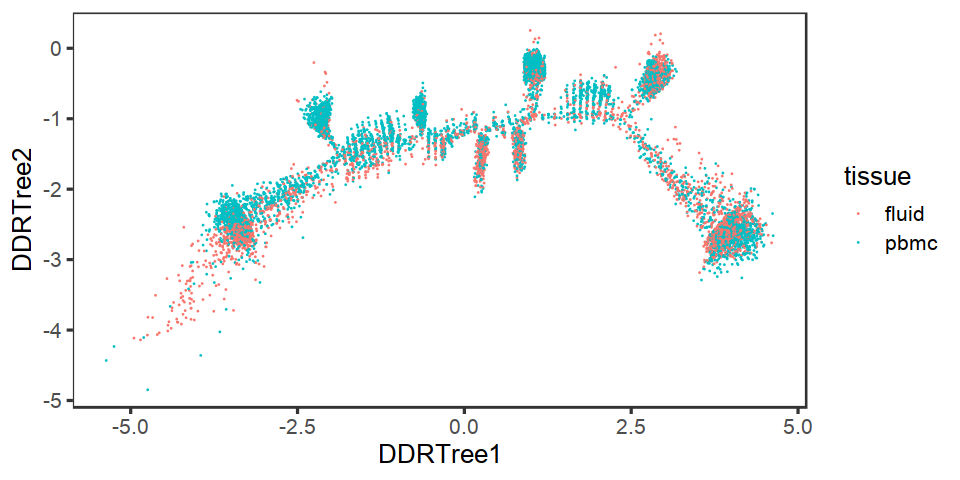

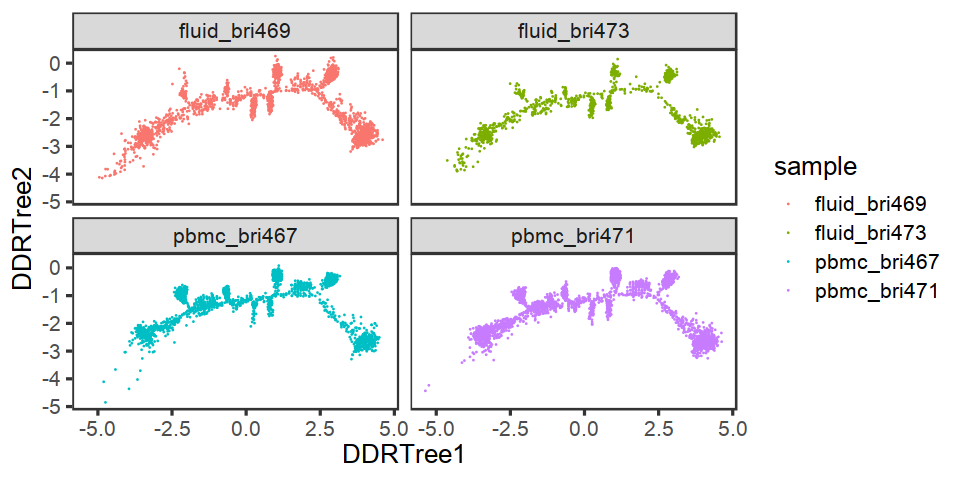

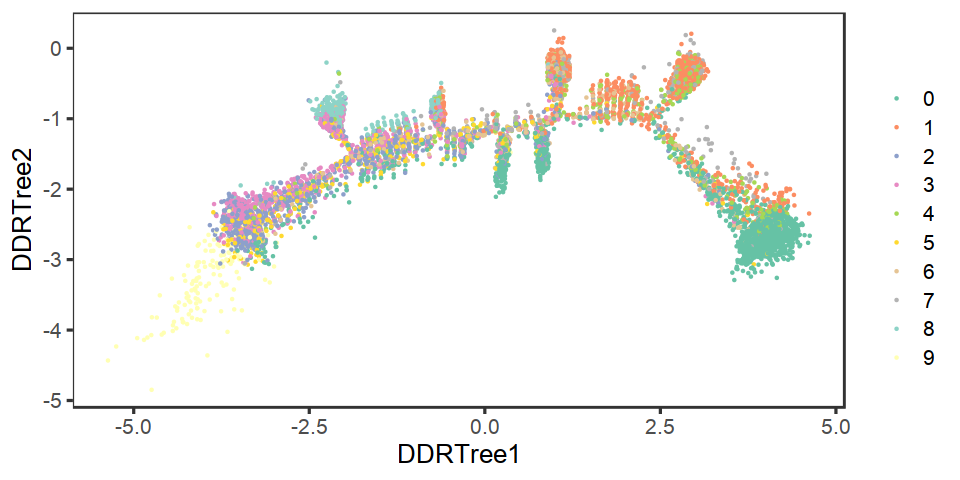

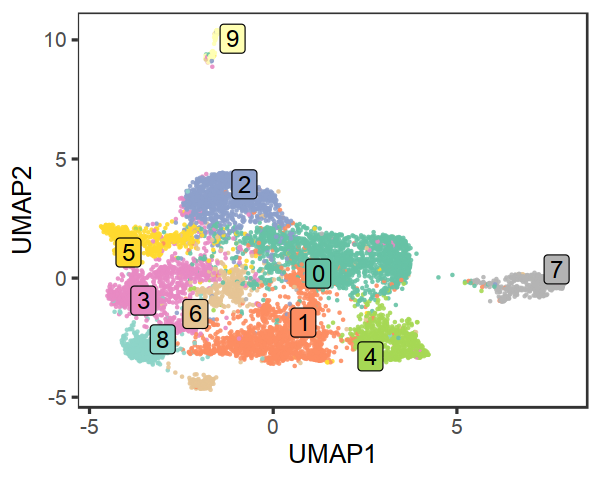

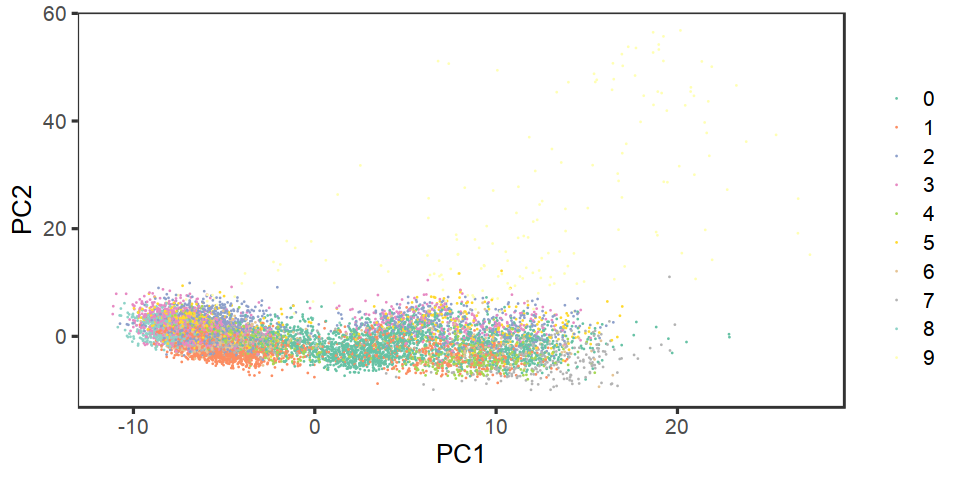

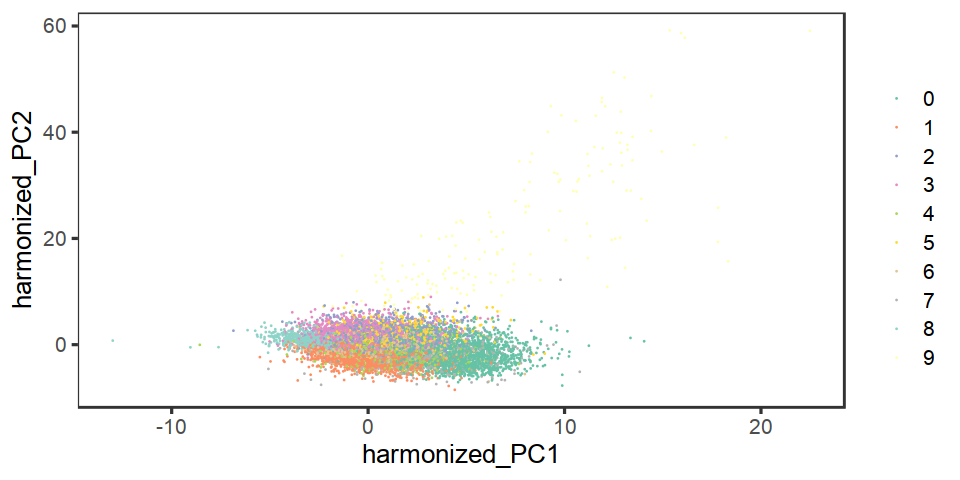

In [105]:
options(repr.plot.height = 4, repr.plot.width = 8)
ggplot() +
  geom_point(
    data = meta_all[sample(nrow(meta_all)),], 
    mapping = aes_string(x = "DDRTree1", y = "DDRTree2", fill = "cluster_name"),
    size = 0.5, stroke = 0.0001, shape = 21
  ) +
#   scale_fill_manual(values = meta_colors$cluster, name = "") +
  theme_bw(base_size = 15) +
  theme(
#     legend.position = "none",
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=10)
  ) 


ggplot() +
  geom_point(
    data = meta_all[sample(nrow(meta_all)),], 
    mapping = aes_string(x = "DDRTree1", y = "DDRTree2", fill = "sample"),
    size = 0.5, stroke = 0.0001, shape = 21
  ) +
  facet_wrap(~ sample) +
  theme_bw(base_size = 15) +
  theme(
#     legend.position = "none",
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=10)
  ) 


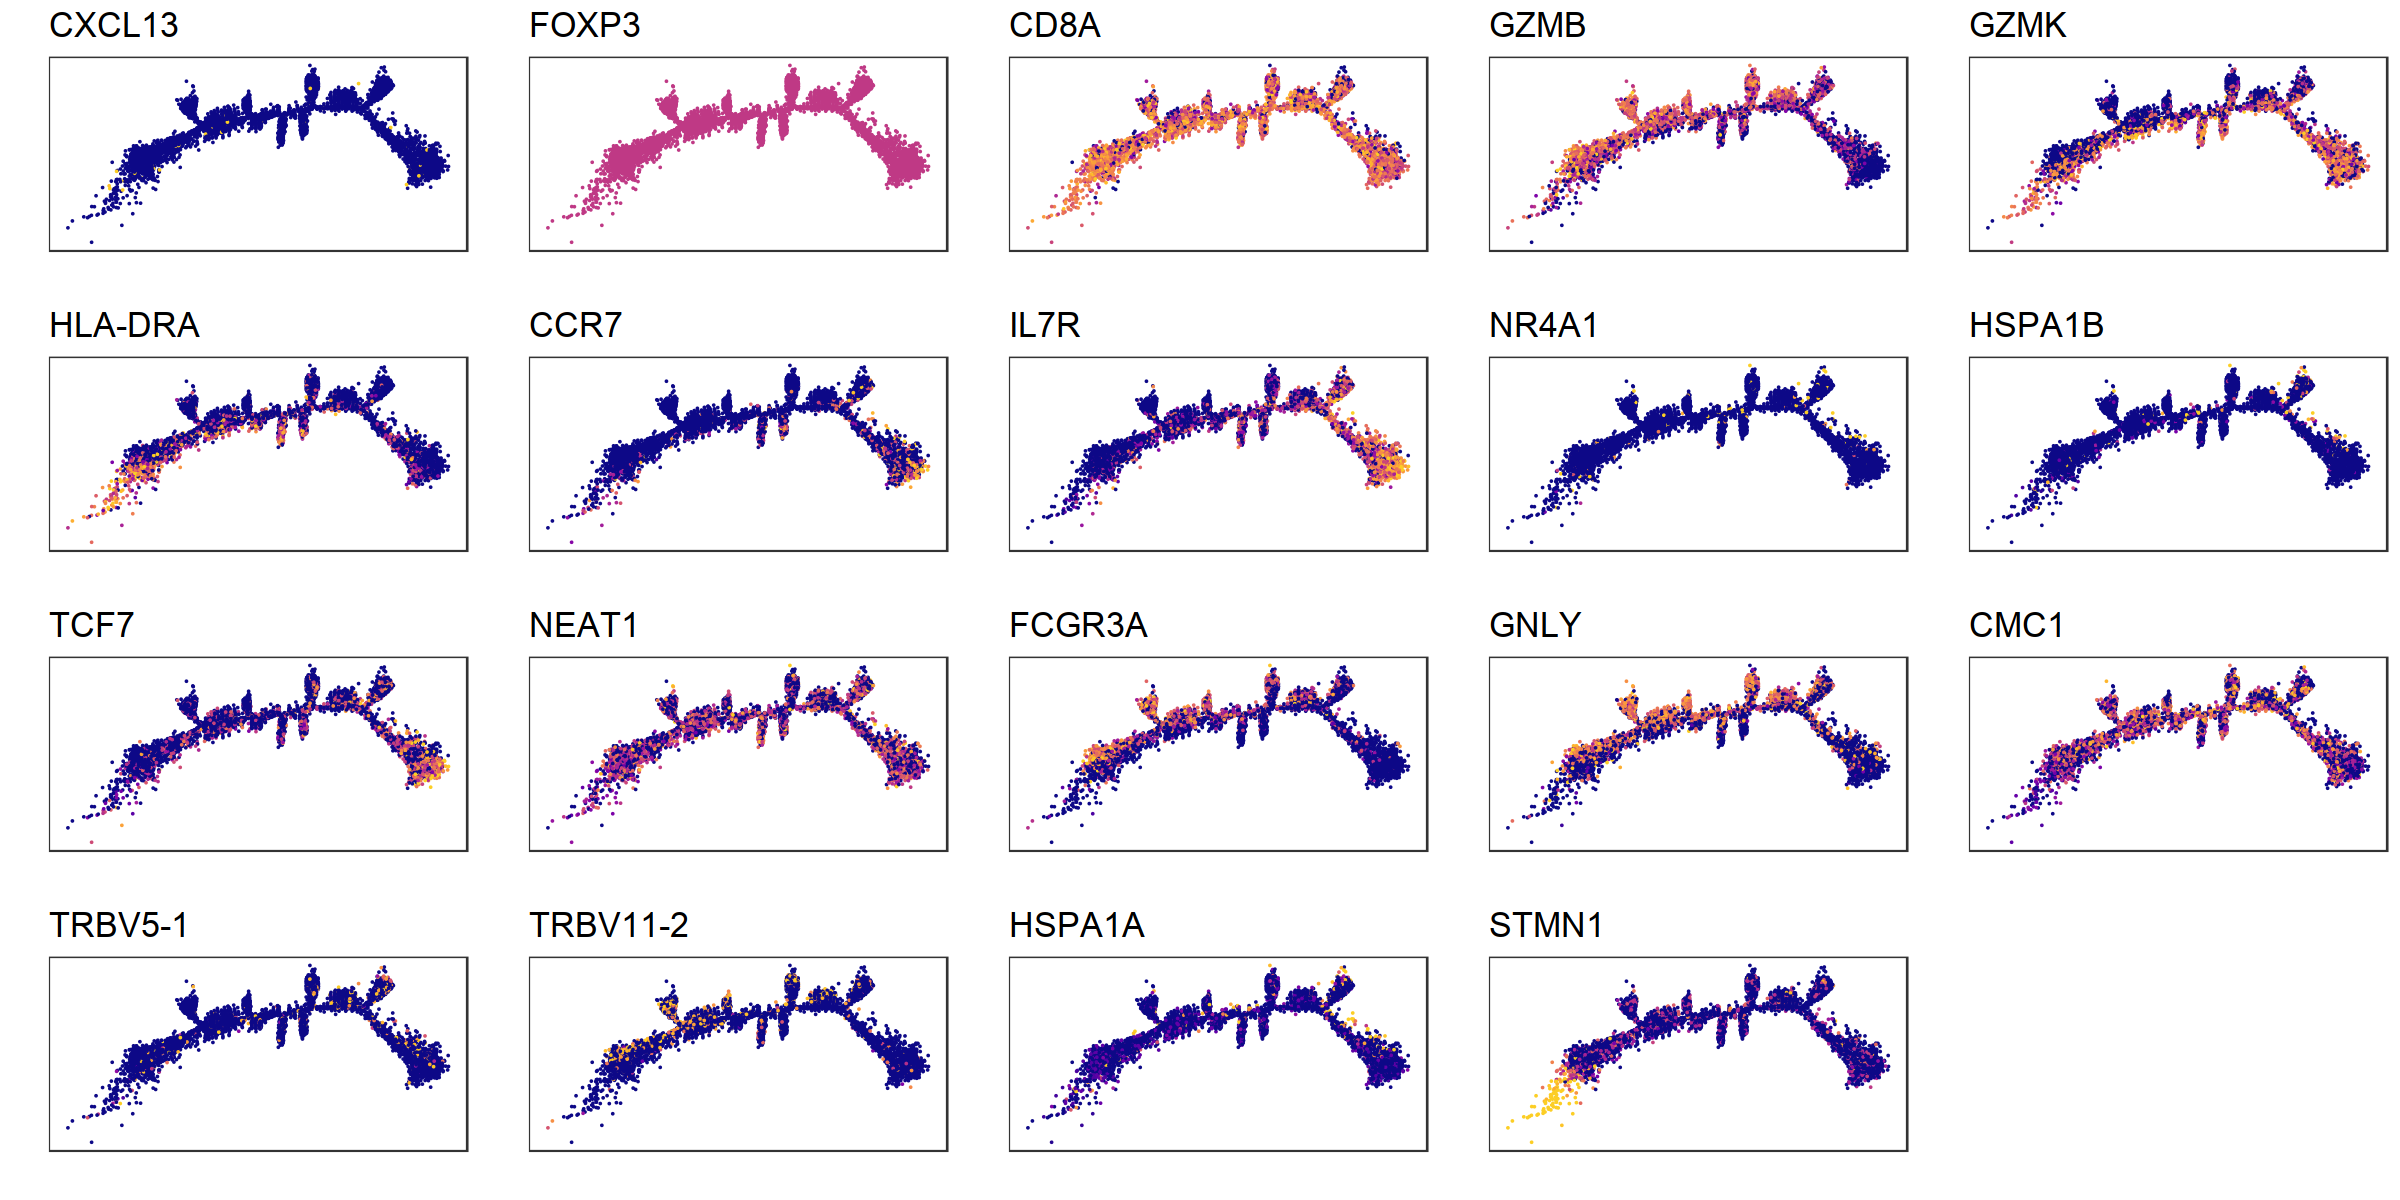

In [107]:
plot_protein <- c( "CXCL13", "FOXP3", "CD8A", "GZMB", "GZMK", "HLA-DRA", "CCR7", "IL7R", "NR4A1","HSPA1B", "TCF7", "NEAT1", "FCGR3A")
plot_protein <- union(plot_protein, x$feature)

myplots <- list()
for (i in 1:length(plot_protein)) {
  gene <- plot_protein[i]
    
    max.cutoff = quantile(exprs_norm_cd8_pure[gene,], .99)
    min.cutoff = quantile(exprs_norm_cd8_pure[gene,], .01)

    tmp <- sapply(X = exprs_norm_cd8_pure[gene,], FUN = function(x) {
        return(ifelse(test = x > max.cutoff, yes = max.cutoff,
            no = x))
    })
    tmp <- sapply(X = tmp, FUN = function(x) {
        return(ifelse(test = x < min.cutoff, yes = min.cutoff,
            no = x))
    })
  
    meta_cd8_pure$gene <- as.numeric(tmp)
    

    
   ind <- paste("p", i, sep = "")
   ind <- ggplot(
                 data = meta_cd8_pure[sample(nrow(meta_cd8_pure)),],
#                  data = meta_all[order(meta_all$gene),] , 
                 aes(x = DDRTree1, y = DDRTree2)) + 
      geom_point(mapping = aes(color = gene), size = 0.0001) + 
      scale_color_viridis(option = "plasma", end = .9) +
      labs(x="", y="")+
      theme_bw(base_size = 15)+
      theme(
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=20), # face="bold.italic"
        legend.position = "none") +
      labs(title = gene)
   myplots[[i]] <- ind
    
    
}

options(repr.plot.height = 10, repr.plot.width = 20)
p <- do.call("grid.arrange", c(myplots, ncol = 5))

In [110]:
all(colnames(exprs_norm_cd8_pure) == meta_cd8_pure$cell)
meta_cd8_pure[1:4,]

saveRDS(meta_cd8_pure, "meta_cd8_pure_helena_cd8_tis_bld_2021-02-01.rds")
saveRDS(exprs_norm_cd8_pure, "exprs_norm_cd8_pure_helena_cd8_tis_bld_2021-02-01.rds")

[1] TRUE

,cell,sample,patient,tissue,nUMI,nGene,percent_mito,PC1,PC2,PC3,...,harmonized_PC19,harmonized_PC20,UMAP1,UMAP2,res_0.40,res_0.60,res_0.80,gene,DDRTree1,DDRTree2
pbmc_bri467AAACCTGAGAACAACT-1,pbmc_bri467AAACCTGAGAACAACT-1,pbmc_bri467,PO12,pbmc,4914,1897,0.09910460,-6.644584,-0.4887441,4.174464,...,0.02218148,0.4918970,-1.623506,4.2112601,2,2,2,0.0000000,-3.265122,-2.2805233
pbmc_bri467AAACCTGAGGCCATAG-1,pbmc_bri467AAACCTGAGGCCATAG-1,pbmc_bri467,PO12,pbmc,4258,1748,0.06176609,-9.478218,-0.8112555,5.773941,...,2.56354464,-0.7595621,-3.328962,-3.0251983,8,9,9,0.0000000,-2.204343,-0.7004192
pbmc_bri467AAACCTGAGTCGCCGT-1,pbmc_bri467AAACCTGAGTCGCCGT-1,pbmc_bri467,PO12,pbmc,5571,1622,0.06910788,-4.466801,-4.5571058,4.588935,...,0.58190453,0.6146727,1.059936,-2.5440469,1,0,0,0.0000000,2.923846,-0.3515856
pbmc_bri467AAACCTGGTACCAGTT-1,pbmc_bri467AAACCTGGTACCAGTT-1,pbmc_bri467,PO12,pbmc,6193,1992,0.06006782,-6.793883,0.3291609,4.547480,...,3.66666688,1.3989349,-3.465338,-0.7579835,3,3,4,0.9611594,-3.417563,-2.3519561


In [167]:
library(monocle)

In [169]:
harmony_Z <- t(everything_meta[, c(149:158)]) # first 10 PCs
ncells <- ncol(harmony_Z)
ncenter <- round(6 * 100 * log(ncells) / (log(ncells) + log(100)))
ddr_args <- c(list(
        X = harmony_Z, 
        dimensions = 2, ## LOW DIMENSIONALITY
        ncenter = ncenter, ## number of nodes allowed in the regularization graph
        param.gamma = 10, ## param.gamma regularization parameter for k-means 
        maxIter = 30,
        tol = 1e-3,
        verbose = FALSE))
ddrtree_res <<- do.call(DDRTree, ddr_args)

library(princurve)
pc_res <- principal_curve(t(ddrtree_res$Z))
everything_meta$pseudo_sam5_10PC <- pc_res$lambda

In [237]:
test$CCR7 <- everything_norm["CCR7",]
test$GZMK <- everything_norm["GZMK",]
test$GZMB <- everything_norm["GZMB",]
test$HLA <- everything_norm["HLA-DRA",]
test$MKI67 <- everything_norm["MKI67",]
test$IL7R <- everything_norm["IL7R",]

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


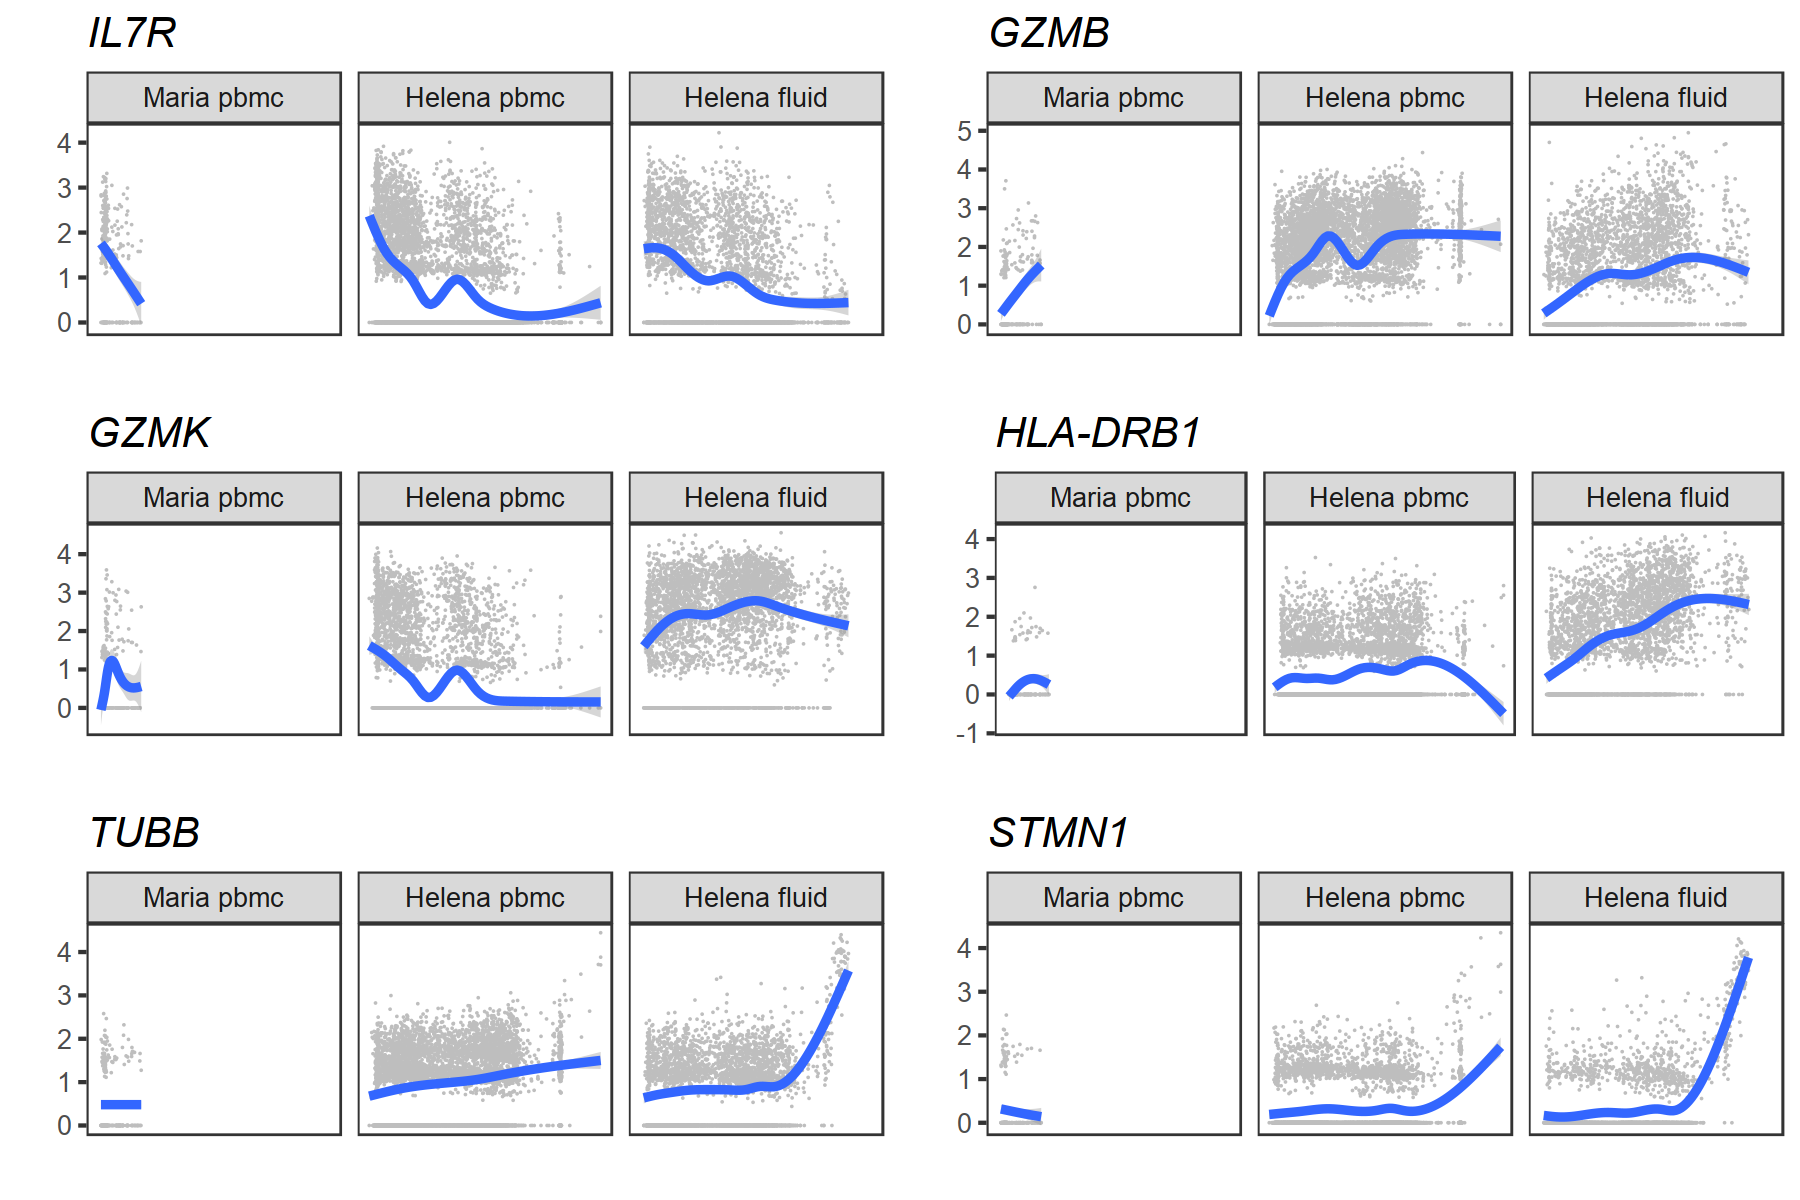

In [504]:
# plot_protein <- c("SELL", "IL7R", "RPS12", "GZMB", "GZMK", "HLA-DRB1", "TUBB")
plot_protein <- c( "IL7R", "GZMB", "GZMK", "HLA-DRB1", "TUBB", "STMN1")

myplots <- list()
for (i in 1:length(plot_protein)) {
  gene <- plot_protein[i]
  
    test$gene <- as.numeric(everything_norm[gene,])    
    test$dataset <- factor(test$dataset, c("Maria pbmc", "Helena pbmc", "Helena fluid")) 
    
    ind <- paste("p", i, sep = "")
    ind <- ggplot(# test, 
                  test[-which(test$dataset == "Maria pbmc" & test$pseudo_sam5_10PC < 30),], # Remove outliers from Maria pbmc data
                  aes(x = -pseudo_sam5_10PC, y = gene)
                 ) +
       geom_point(size = 0.00001, color = "grey") +
       geom_smooth( size=2 ) +
       facet_wrap(~ dataset, ncol = 3) +
       labs(x = "", y = "") +
       theme_bw(base_size = 20)+
       theme(
         axis.text.x = element_blank(),
         axis.ticks.x = element_blank(),
         panel.grid = element_blank(),
         plot.title = element_text(color="black", size=25, face="italic"),
         legend.position = "none"
       ) +
       labs(title = gene)
   myplots[[i]] <- ind
    
    
}

options(repr.plot.height = 10, repr.plot.width = 15)
p <- do.call("grid.arrange", c(myplots, ncol = 2))
ggsave(file = paste("pseudo_vs_gene_dataset", ".png", sep = ""), p,  width = 15, height = 10, dpi = 300)

## Obtain genes associated with the pseduo_sam5_10PC

In [202]:
library(lm.beta)

In [255]:
count <- readRDS("everything_exp_2021-02-01.rds")
count <- as(as.matrix(count), "sparseMatrix")  
dim(count)

[1] 22109  9837

In [256]:
# Subset by variable genes
var_genes = vargenes_vst(count, topn = 500, groups = everything_meta$sample)
head(var_genes)
length(var_genes)

[1] "HSPA6"   "HSPA1A"  "TRBV7-2" "GNLY"    "HSPA1B"  "TRBV4-2"

[1] 1817

In [257]:
count <- t(count[var_genes,])
dim(count)

[1] 9837 1817

In [386]:
glm_offset <- glm(count[,"RPS3A"] ~ everything_meta$pseudo_sam5_10PC + everything_meta$sample + offset(log(everything_meta$nUMI) + everything_meta$percent_mito), family = "poisson")
as.numeric(coef(summary(glm_offset))[,4][2])
lm.beta(glm_offset)$standardized.coefficients[2] 

glm_offset <- glm(count[,"RPS3A"] ~ everything_meta$pseudo_sam5_10PC + offset(log(everything_meta$nUMI) + everything_meta$percent_mito), family = "poisson")
as.numeric(coef(summary(glm_offset))[,4][2])
lm.beta(glm_offset)$standardized.coefficients[2] 

glm_offset <- glm(count[,"RPS3A"] ~ everything_meta$pseudo_sam5_10PC +  offset(log(everything_meta$nUMI)), family = "poisson")
as.numeric(coef(summary(glm_offset))[,4][2])
lm.beta(glm_offset)$standardized.coefficients[2] 



[1] 0

everything_meta$pseudo_sam5_10PC 
                      0.01667625

[1] 0

everything_meta$pseudo_sam5_10PC 
                      0.01887056

[1] 0

everything_meta$pseudo_sam5_10PC 
                       0.0192436

In [369]:
p_glm <- c()
beta <- c()

for (i in 1:ncol(count)) {
    glm_offset <- glm(count[,i] ~ everything_meta$pseudo_sam5_10PC + offset(log(everything_meta$nUMI)), family = "poisson")
#         glm_offset <- glm.nb(count[,i] ~ everything_meta$pseudo_sam5_10PC + offset(log(everything_meta$nUMI)))
    lm.beta(glm_offset)
    p_glm[i] <- as.numeric(coef(summary(glm_offset))[,4][2])
    beta[i] <- lm.beta(glm_offset)$standardized.coefficients[2] 
}

fit.df <- data.frame(p = p_glm,
                     beta = beta)

head(p_glm)

Warning message:
“glm.fit: fitted rates numerically 0 occurred”Warning message:
“glm.fit: fitted rates numerically 0 occurred”Warning message:
“glm.fit: fitted rates numerically 0 occurred”Warning message:
“glm.fit: fitted rates numerically 0 occurred”Warning message:
“glm.fit: fitted rates numerically 0 occurred”Warning message:
“glm.fit: fitted rates numerically 0 occurred”Warning message:
“glm.fit: fitted rates numerically 0 occurred”

[1]  0.000000e+00  0.000000e+00  1.101401e-18  1.582539e-17 8.393153e-266
[6]  2.020416e-04

In [397]:
rownames(fit.df) <- colnames(count)
g_pos <- fit.df[which(fit.df$p < 1e-3/ncol(count) & fit.df$beta > 0),]
g_pos <- g_pos[order(g_pos$p, -g_pos$beta),]
# g_pos <- g_pos[order(-g_pos$beta, g_pos$p),]
g_pos <- g_pos[1:20,]
g_pos[1:5,]


g_neg <- fit.df[which(fit.df$p < 1e-3/ncol(count) & fit.df$beta < 0),]
g_neg <- g_neg[order(g_neg$p, g_neg$beta),]
# g_neg <- g_neg[order(g_neg$beta),]
g_neg <- g_neg[1:20,]
g_neg[1:5,]


fit.df[which(rownames(fit.df) == "CCR7"),]
fit.df[which(rownames(fit.df) == "SELL"),]

,p,beta
IL7R,0,0.20901379
HSPA6,0,0.06836028
MT-ND2,0,0.05168425
RPL9,0,0.05038590
PABPC1,0,0.04437197


,p,beta
MKI67,0,-3.4208471
TYMS,0,-2.1563291
STMN1,0,-0.3588211
HLA-DRA,0,-0.2443300
ANXA2,0,-0.1589254


,p,beta
CCR7,8.990151e-130,0.7280527


,p,beta
SELL,6.224738e-84,0.1857913


In [405]:
ncol(count)

[1] 1817

[1] TRUE

[1]   35 9837

png 
  4

png 
  2

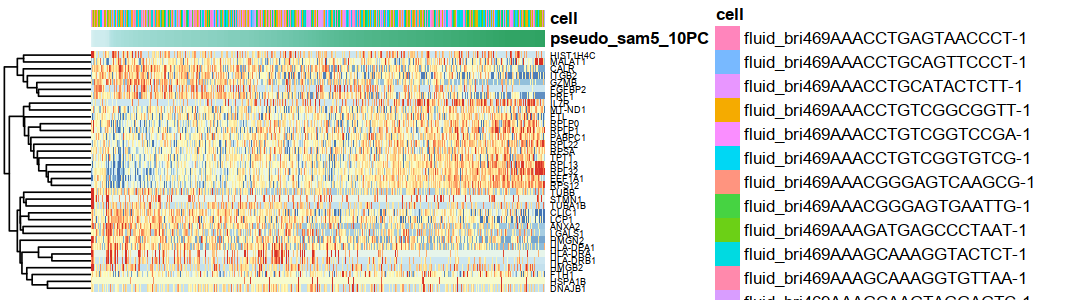

In [438]:
# Order on p and beta
g_pos <- fit.df[which(fit.df$p < 1e-3/ncol(count) & fit.df$beta > 0),]
g1 <- g_pos[order(g_pos$p, -g_pos$beta),][1:30,] 
# g2 <- g_pos[order(-g_pos$beta, g_pos$p),][1:10,]
g_neg <- fit.df[which(fit.df$p < 1e-3/ncol(count) & fit.df$beta < 0),]
g3 <- g_neg[order(g_neg$p, g_neg$beta),][1:20,]
# g4 <- g_neg[order(g_neg$beta, g_neg$p),][1:10,]

pseudo_mat <- everything_norm[which(rownames(everything_norm) %in% Reduce(union, list(rownames(g1), rownames(g3) )) ), ]
pseudo_mat <- pseudo_mat[-which(rownames(pseudo_mat) %in% c("RPS3A", "RPS13", "RPL34", "RPS6", "RPL9", "RPS8", "RPL11", "RPS18", "RPS2", "RPL39",
                                                            "TYMS", "MKI67", "HSPA1A", "HSPA1B", "HSPA6", "MT-ND2")), ] 

annotation_col <- everything_meta[order(everything_meta$pseudo_sam5_10PC), ]
annotation_col <- annotation_col[, c("cell", "pseudo_sam5_10PC")]
rownames(annotation_col) <- annotation_col$cell
annotation_col <- annotation_col[order(rev(annotation_col$pseudo_sam5_10PC)),]

pseudo_mat <- pseudo_mat[, match(annotation_col$cell, colnames(pseudo_mat))]
# gene_order <- c('RPL22',  'RPL13','RPL32', 'IL7R', 'STMN1', 'FTL', 'HMGN2',  'FGFBP2', 'HMGB2',  'HIST1H4C', 'TUBB', 'CLIC1', 
#                 'PABPC1', 'PRF1','TUBA1B', 'LCP1', 'GZMB', 'ANXA2', 'CALR', 'DNAJB1', 'LGALS1', 'ITGB2',  'HLA-DRA',
#                 'HLA-DRB1', 'HLA-DPA1')
# pseudo_mat <- pseudo_mat[match(gene_order, rownames(pseudo_mat)), ]

all(rownames(annotation_col) == colnames(pseudo_mat))
annotation_col <- annotation_col[, c("pseudo_sam5_10PC", "cell")]
dim(pseudo_mat)

scale_rows <- function(x) t(scale(t(x)))
pseudo_mat <- scale_rows(pseudo_mat)
pseudo_mat[pseudo_mat > 2] <- 2
pseudo_mat[pseudo_mat < -2] <- -2

# Do scale_rows, don't do scale()
# pdf("pseudo_heatmap.pdf", width=9, height=3, onefile = FALSE, bg = "white")
options(repr.plot.width = 9, repr.plot.height = 2.5)
pheatmap(
  mat = pseudo_mat,
  border_color = NA,
#   color  = viridis(15),
  show_rownames = T,
  show_colnames = F,
  fontsize_row = 5,
  cluster_rows = TRUE,
  cluster_cols = FALSE,
  annotation_col = annotation_col,
  legend = FALSE
#   cluster_rows = TRUE,
#   cluster_cols = TRUE
)
dev.copy(png,file = paste("pseudo_heatmap", ".png", sep = ""), width=9, height=2.5, units="in", res=300)
dev.off()

In [469]:
library(scico) 
library(ComplexHeatmap)

subset <- which(rownames(pseudo_mat) %in% c("GZMB", "IL7R", "FGFBP2", "RPL32", "TUBA1B", "CLIC1", "HLA-DRA", "HLA-DRB1", "PRS12", "FTH1", 
                                            "STMN1", "IL7R", "TUBB", "CALR", "DNAJB1", "HIST1H4C", "RPL32", "RPL22", "RPLP0"))
labels = rownames(pseudo_mat)[subset]

# col_fun <- scico(10, palette = 'vik')
col_fun <- rev(brewer.pal(10, "RdYlBu"))

pdf("pseudo_heatmap.pdf", width = 4, height = 4)
Heatmap(pseudo_mat, 
        col = col_fun,
        row_names_gp = gpar(fontsize = 7),
        column_names_rot = 45,
        cluster_rows = TRUE,
        cluster_columns = FALSE,
        show_column_names = FALSE,
        show_row_names = FALSE, 
        show_row_dend = FALSE, 
        show_column_dend = FALSE
       ) +
rowAnnotation(link = row_anno_link(at = subset, labels = labels),
              width = unit(1, "cm") + 
              max_text_width(labels)
             )
dev.off()


Warning message:
“anno_link() is deprecated, please use anno_mark() instead.”

png 
  2

In [466]:
rownames(pseudo_mat)

[1] "RPL22"    "STMN1"    "HMGN2"    "RPL32"    "RPSA"     "FGFBP2"  
 [7] "HMGB2"    "IL7R"     "HIST1H4C" "TUBB"     "CLIC1"    "HLA-DRA" 
[13] "HLA-DRB1" "HLA-DPA1" "EEF1A1"   "RPS12"    "PABPC1"   "FTH1"    
[19] "MALAT1"   "PRF1"     "TUBA1B"   "RPLP0"    "TPT1"     "LCP1"    
[25] "GZMB"     "ANXA2"    "RPLP1"    "RPL13"    "CALR"     "DNAJB1"  
[31] "FTL"      "LGALS1"   "ITGB2"    "MT-ND1"

[1]   80 9837

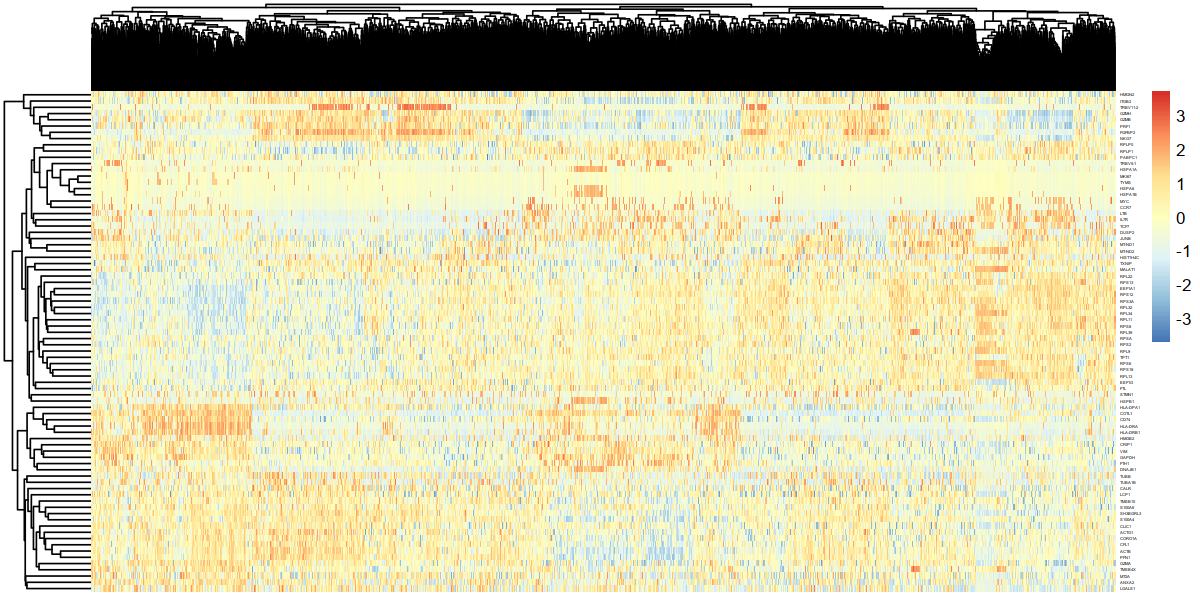

In [326]:
# Order on p and beta
pseudo_mat <- everything_norm[which(rownames(everything_norm) %in% c(rownames(g_pos), rownames(g_neg))), ]
pseudo_mat <- pseudo_mat[, match(everything_meta[order(everything_meta$pseudo_sam5_10PC), ]$cell, colnames(pseudo_mat))]
dim(pseudo_mat)

scale_rows <- function(x) t(scale(t(x)))
pseudo_mat <- scale_rows(pseudo_mat)
pseudo_mat[pseudo_mat > 2] <- 2
pseudo_mat[pseudo_mat < -2] <- -2

options(repr.plot.width = 10, repr.plot.height = 5)
pheatmap(
  mat = scale(pseudo_mat),
  border_color = NA,
#   color  = viridis(15),
  show_rownames = T,
  show_colnames = F,
  fontsize_row = 2,
#   cluster_rows = TRUE,
#   cluster_cols = TRUE
)

[1]   40 9837

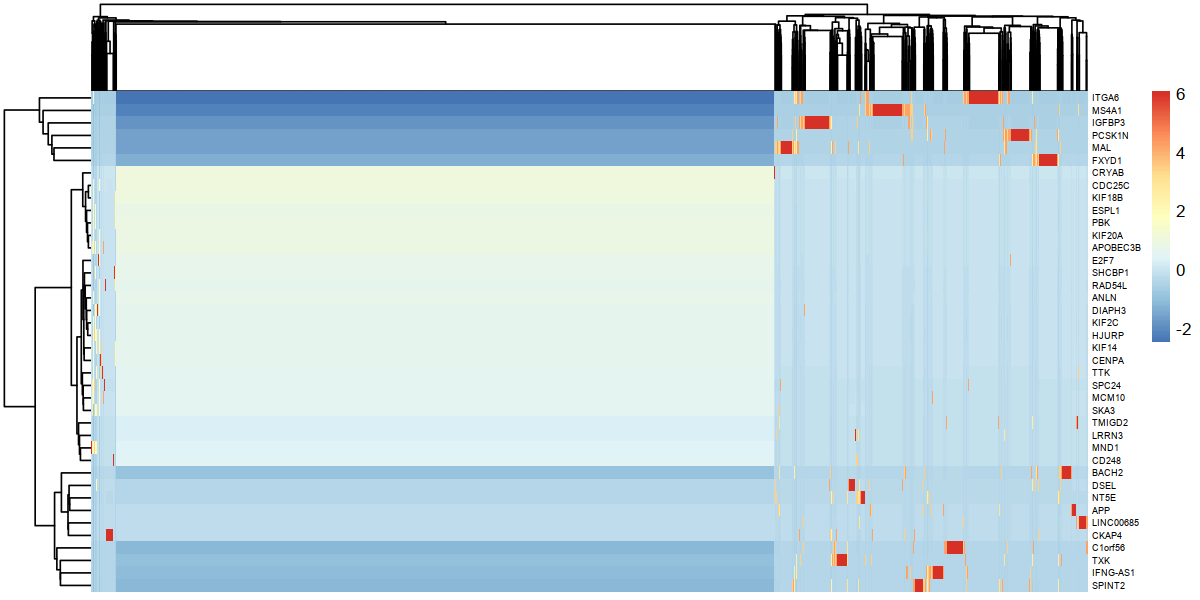

In [323]:
# Order on beta
pseudo_mat <- everything_norm[which(rownames(everything_norm) %in% c(rownames(g_pos), rownames(g_neg))), ]
pseudo_mat <- pseudo_mat[, match(everything_meta[order(everything_meta$pseudo_sam5_10PC), ]$cell, colnames(pseudo_mat))]
dim(pseudo_mat)

scale_rows <- function(x) t(scale(t(x)))
pseudo_mat <- scale_rows(pseudo_mat)
pseudo_mat[pseudo_mat > 2] <- 2
pseudo_mat[pseudo_mat < -2] <- -2

options(repr.plot.width = 10, repr.plot.height = 5)
pheatmap(
  mat = scale(pseudo_mat),
  border_color = NA,
#   color  = viridis(15),
  show_rownames = T,
  show_colnames = F,
  fontsize_row = 5,
#   cluster_rows = TRUE,
#   cluster_cols = TRUE
)

[1]   40 9837

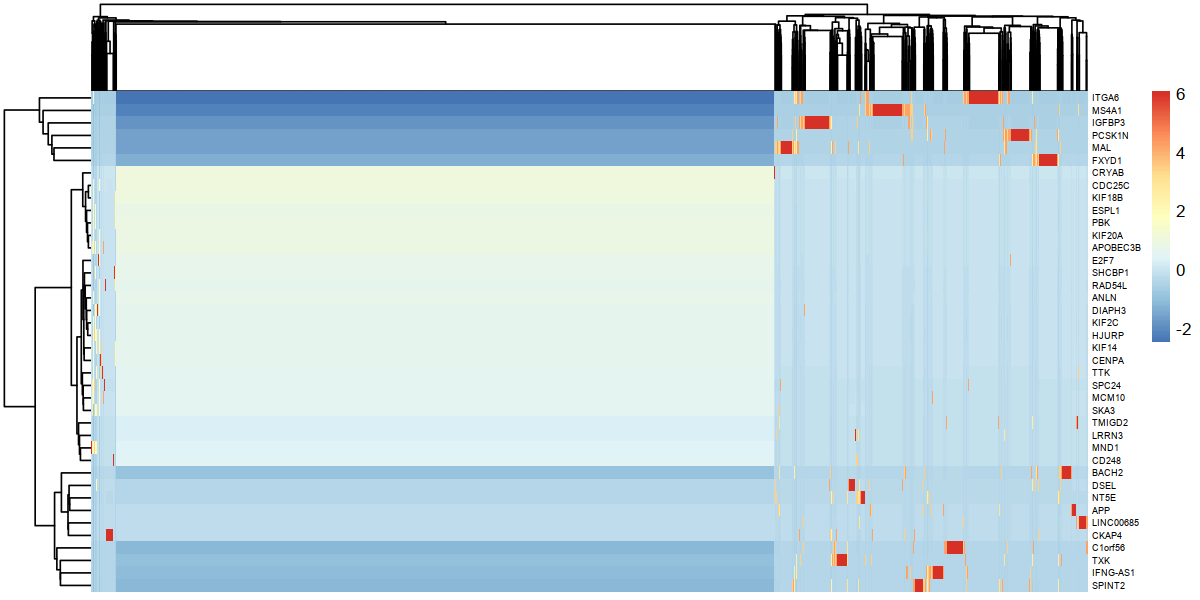

In [321]:
# Order on beta and p
pseudo_mat <- everything_norm[which(rownames(everything_norm) %in% c(rownames(g_pos), rownames(g_neg))), ]
pseudo_mat <- pseudo_mat[, match(everything_meta[order(everything_meta$pseudo_sam5_10PC), ]$cell, colnames(pseudo_mat))]
dim(pseudo_mat)

scale_rows <- function(x) t(scale(t(x)))
pseudo_mat <- scale_rows(pseudo_mat)
pseudo_mat[pseudo_mat > 2] <- 2
pseudo_mat[pseudo_mat < -2] <- -2

options(repr.plot.width = 10, repr.plot.height = 5)
pheatmap(
  mat = scale(pseudo_mat),
  border_color = NA,
#   color  = viridis(15),
  show_rownames = T,
  show_colnames = F,
  fontsize_row = 5,
#   cluster_rows = TRUE,
#   cluster_cols = TRUE
)